In [1]:
import utils
from IPython.display import clear_output
import os
import torch
from time import sleep

!pip install datasets evaluate accelerate deepspeed psutil pybind11 huggingface_hub

clear_output()

print('Pytorch version\t:', torch.__version__)
print('PyTorch CUDA version\t:', torch.version.cuda)

for i in range(torch.cuda.device_count()):
    print(f'GPU{i}\t\t:',torch.cuda.get_device_name(i))

Pytorch version	: 2.0.1+cu117
PyTorch CUDA version	: 11.7


GPU0		: Tesla T4


In [2]:
try:
    import apex
except ImportError:
    print("Installing apex")
    !git clone https://github.com/NVIDIA/apex.git || true
    clear_output()

    !cd apex; git checkout 2386a912164b0c5cfcd8be7a2b890fbac5607c82; python setup.py install --cuda_ext --cpp_ext 

In [3]:
!cd transformers; git stash; git checkout ef42cb62744e2be04f5b41b7e36dd1d609734675
clear_output()

!cd transformers; git apply patches/trainer.patch; git status

# Install the changed transformers without checking dependencies (otherwise it may ruin your PyTorch setting...)
!cd transformers; pip install -e ".[dev]" --no-deps

from utils import hf, Exp, compare

HEAD detached at ef42cb627
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   examples/pytorch/contrastive-image-text/run_clip.py
	modified:   examples/pytorch/image-classification/run_image_classification.py
	modified:   src/transformers/trainer.py
	modified:   src/transformers/trainer_pt_utils.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	5.patch
	beans_outputs/
	benchmark.patch
	dummy_data/
	log.txt
	patches/
	src/transformers/models/bert/modeling_bert.py.rej
	src/transformers/models/groupvit/modeling_groupvit.py.rej

no changes added to commit (use "git add" and/or "git commit -a")
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///home/ubuntu/pytorch-opt/transformers-benchmarks/transformers
  Installing build dependencies ... done
  Checking if build backend supports build_edit

In [4]:
def build_package(name, url):
    import importlib
    import os, sys
    if importlib.util.find_spec(name) is None:
        os.system(f"git clone {url} {name} || true")
        os.system(f"cd {name}; git submodule update --init --recursive")
        os.system(f"cd {name}; pip3 install -r requirements.txt || true")
        os.system(f'cd {name}; pip3 install -e ".[dev]"') 

build_package("xformers", "https://github.com/facebookresearch/xformers.git")
build_package("epoi", "https://github.com/comaniac/epoi.git")

## Bert

In [5]:
bert_8_vanilla = hf(Exp('bert-vanilla', 'bert-large-uncased', 8, fp16=True,
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: export CUDA_VISIBLE_DEVICES=0; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name bert-large-uncased --tokenizer_name bert-large-uncased --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 512 --per_device_train_batch_size 8 --fp16 True --bf16 False --optim adamw_hf --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex --fp16_opt_level=O2 > log/log_bert-vanilla.txt 2>&1
Output: 
Total samples / second	: 9.4
Per GPU memory (GB)	: 14.1
Per GPU TFLOPs		: 10.4


In [6]:
bert_8_softmax = hf(Exp('bert-softmax', 'bert-large-uncased', 8, fp16=True, patch='patches/bert_softmax.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/bert_softmax.patch; git diff src/transformers/models/
Output: No local changes to save
diff --git a/src/transformers/models/bert/modeling_bert.py b/src/transformers/models/bert/modeling_bert.py
index 1b0fad3f9..d19be46d3 100755
--- a/src/transformers/models/bert/modeling_bert.py
+++ b/src/transformers/models/bert/modeling_bert.py
@@ -51,6 +51,11 @@ from ...utils import (
 )
 from .configuration_bert import BertConfig
 
+try:
+    from xformers.triton.softmax import softmax as xformers_softmax
+except ImportError:
+    xformers_softmax = None
+
 
 logger = logging.get_logger(__name__)
 
@@ -352,7 +357,8 @@ class BertSelfAttention(nn.Module):
             attention_scores = attention_scores + attention_mask
 
         # Normalize the attention scores to probabilities.
-        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
+  

In [7]:
bert_8_biasgelu = hf(Exp('bert-biasgelu', 'bert-large-uncased', 8, fp16=True, patch='patches/bert_biasgelu.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/bert_biasgelu.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/bert/modeling_bert.py b/src/transformers/models/bert/modeling_bert.py
index 1b0fad3f9..b49bd5ede 100755
--- a/src/transformers/models/bert/modeling_bert.py
+++ b/src/transformers/models/bert/modeling_bert.py
@@ -442,10 +442,10 @@ class BertIntermediate(nn.Module):
     def __init__(self, config):
         super().__init__()
         self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
-        if isinstance(config.hidden_act, str):
-            self.intermediate_act_fn = ACT2FN[config.hidden_act]
-        else:
-            self.intermediate_act_fn = config.hidden_act
+        from epoi.ops.torchscript_ops import FusedBiasGE

In [8]:
bert_8_dropoutlayernorm = hf(Exp('bert-dropoutlayernorm', 'bert-large-uncased', 8, fp16=True, patch='patches/bert_dropoutlayernorm.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/bert_dropoutlayernorm.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/bert/modeling_bert.py b/src/transformers/models/bert/modeling_bert.py
index 1b0fad3f9..5482bdf71 100755
--- a/src/transformers/models/bert/modeling_bert.py
+++ b/src/transformers/models/bert/modeling_bert.py
@@ -379,13 +379,13 @@ class BertSelfOutput(nn.Module):
     def __init__(self, config):
         super().__init__()
         self.dense = nn.Linear(config.hidden_size, config.hidden_size)
-        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
-        self.dropout = nn.Dropout(config.hidden_dropout_prob)
+        from epoi.ops.torchscript_ops import FusedDropoutAddLayerNorm
+        self.dropout_ad

In [9]:
bert_8_attention = hf(Exp('bert-attention', 'bert-large-uncased', 8, fp16=True, patch='patches/bert_attention.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/bert_attention.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/bert/modeling_bert.py b/src/transformers/models/bert/modeling_bert.py
index 1b0fad3f9..5b0b61ce4 100755
--- a/src/transformers/models/bert/modeling_bert.py
+++ b/src/transformers/models/bert/modeling_bert.py
@@ -392,7 +392,8 @@ class BertSelfOutput(nn.Module):
 class BertAttention(nn.Module):
     def __init__(self, config, position_embedding_type=None):
         super().__init__()
-        self.self = BertSelfAttention(config, position_embedding_type=position_embedding_type)
+        from epoi.ops.xformers_attn import BertSelfAttentionWithXF as xFormersBertSelfAttention
+        self.self = xFormersBertSelfAttention(config, position_embed

In [10]:
bert_8_all = hf(Exp('bert-all', 'bert-large-uncased', 8, fp16=True, patch='patches/bert_all.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/bert_all.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/bert/modeling_bert.py b/src/transformers/models/bert/modeling_bert.py
index 1b0fad3f9..464737401 100755
--- a/src/transformers/models/bert/modeling_bert.py
+++ b/src/transformers/models/bert/modeling_bert.py
@@ -352,7 +352,8 @@ class BertSelfAttention(nn.Module):
             attention_scores = attention_scores + attention_mask
 
         # Normalize the attention scores to probabilities.
-        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
+        from xformers.triton.softmax import softmax
+        attention_probs = softmax(attention_scores)
 
         # This is actually dropping out entire tokens to attend to, which mig

Samples / sec: ['9.43', '8.75', '9.88', '9.16', '11.56', '9.61']
per GPU TFLOPS: ['10.38', '9.64', '10.87', '10.08', '12.72', '10.58']
per GPU memory (GB): ['14.13', '14.40', '12.95', '14.13', '11.72', '11.72']


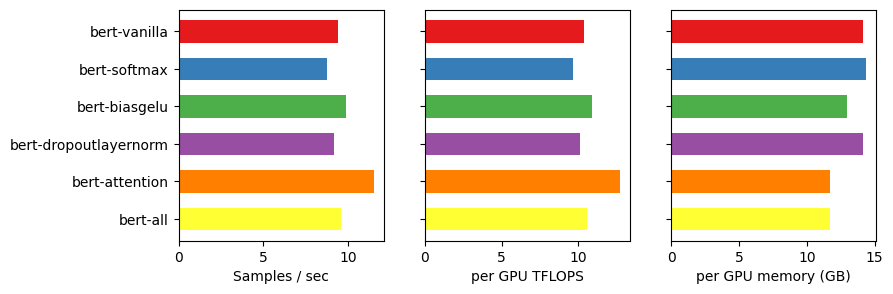

In [11]:
compare([bert_8_vanilla, bert_8_softmax, bert_8_biasgelu, bert_8_dropoutlayernorm, bert_8_attention, bert_8_all], 'bert')

## Roberta

In [12]:
roberta_8_vanilla = hf(Exp('roberta-vanilla', 'roberta-base', 16, fp16=True, seq_len=128, 
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: export CUDA_VISIBLE_DEVICES=0; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name roberta-base --tokenizer_name roberta-base --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 128 --per_device_train_batch_size 16 --fp16 True --bf16 False --optim adamw_hf --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex > log/log_roberta-vanilla.txt 2>&1
Output: 
Total samples / second	: 65.2
Per GPU memory (GB)	: 4.5
Per GPU TFLOPs		: 6.3


In [13]:
roberta_8_softmax = hf(Exp('roberta-softmax', 'roberta-base', 16, fp16=True, seq_len=128, 
                    patch='patches/roberta_softmax.patch', kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/roberta_softmax.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/roberta/modeling_roberta.py b/src/transformers/models/roberta/modeling_roberta.py
index 6d4cc991d..f40039882 100644
--- a/src/transformers/models/roberta/modeling_roberta.py
+++ b/src/transformers/models/roberta/modeling_roberta.py
@@ -263,7 +263,8 @@ class RobertaSelfAttention(nn.Module):
             attention_scores = attention_scores + attention_mask
 
         # Normalize the attention scores to probabilities.
-        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
+        from xformers.triton.softmax import softmax as softmax_softmax
+        attention_probs = softmax_softmax(attention_scores)
 
         # This i

In [14]:
roberta_8_biasgelu = hf(Exp('roberta-biasgelu', 'roberta-base', 16, fp16=True, seq_len=128, 
                    patch='patches/roberta_biasgelu.patch', kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/roberta_biasgelu.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/roberta/modeling_roberta.py b/src/transformers/models/roberta/modeling_roberta.py
index 6d4cc991d..ffcac91c5 100644
--- a/src/transformers/models/roberta/modeling_roberta.py
+++ b/src/transformers/models/roberta/modeling_roberta.py
@@ -355,11 +355,11 @@ class RobertaAttention(nn.Module):
 class RobertaIntermediate(nn.Module):
     def __init__(self, config):
         super().__init__()
-        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
-        if isinstance(config.hidden_act, str):
-            self.intermediate_act_fn = ACT2FN[config.hidden_act]
-        else:
-            self.intermediate_act_fn = config.hi

In [15]:
roberta_8_dropoutlayernorm = hf(Exp('roberta-dropoutlayernorm', 'roberta-base', 16, fp16=True, seq_len=128, 
                    patch='patches/roberta_dropoutlayernorm.patch', kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/roberta_dropoutlayernorm.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/roberta/modeling_roberta.py b/src/transformers/models/roberta/modeling_roberta.py
index 6d4cc991d..f25b39c07 100644
--- a/src/transformers/models/roberta/modeling_roberta.py
+++ b/src/transformers/models/roberta/modeling_roberta.py
@@ -291,13 +291,12 @@ class RobertaSelfOutput(nn.Module):
     def __init__(self, config):
         super().__init__()
         self.dense = nn.Linear(config.hidden_size, config.hidden_size)
-        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
-        self.dropout = nn.Dropout(config.hidden_dropout_prob)
+        from epoi.ops.torchscript_ops import FusedDropoutAddLaye

In [16]:
roberta_8_all = hf(Exp('roberta-all', 'roberta-base', 16, fp16=True, seq_len=128, 
                    patch='patches/roberta_all.patch', kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/roberta_all.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/roberta/modeling_roberta.py b/src/transformers/models/roberta/modeling_roberta.py
index 6d4cc991d..9f7f26906 100644
--- a/src/transformers/models/roberta/modeling_roberta.py
+++ b/src/transformers/models/roberta/modeling_roberta.py
@@ -263,7 +263,8 @@ class RobertaSelfAttention(nn.Module):
             attention_scores = attention_scores + attention_mask
 
         # Normalize the attention scores to probabilities.
-        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
+        from xformers.triton.softmax import softmax
+        attention_probs = softmax(attention_scores)
 
         # This is actually dropping out entire 

Samples / sec: ['65.15', '15.26', '53.53', '69.12', '13.62']
per GPU TFLOPS: ['6.30', '1.48', '5.18', '6.68', '1.32']
per GPU memory (GB): ['4.52', '3.82', '3.80', '3.80', '3.83']


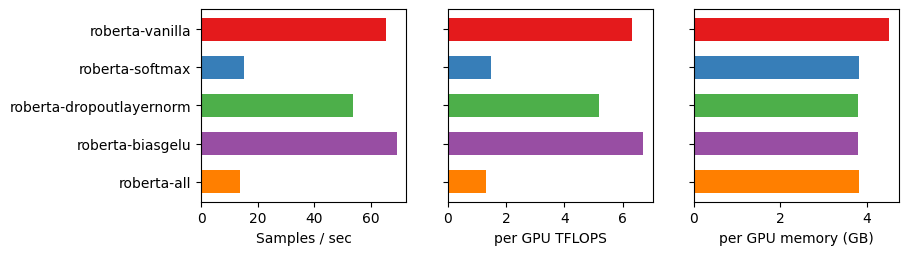

In [17]:
compare([roberta_8_vanilla, roberta_8_softmax, roberta_8_dropoutlayernorm, roberta_8_biasgelu, roberta_8_all], 'roberta')

## GPT2

In [18]:
gpt2_4_vanilla = hf(Exp('gpt2-vanilla', 'gpt2', 4, fp16=True, 
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: export CUDA_VISIBLE_DEVICES=0; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_clm.py --config_name gpt2 --tokenizer_name gpt2 --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --per_device_train_batch_size 4 --fp16 True --bf16 False --optim adamw_hf --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/gptneo/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex > log/log_gpt2-vanilla.txt 2>&1
Output: 
Total samples / second	: 5.6
Per GPU memory (GB)	: 12.4
Per GPU TFLOPs		: 4.9


In [19]:
gpt2_4_softmax = hf(Exp('gpt2-softmax', 'gpt2', 4, fp16=True, patch='patches/gpt2_softmax.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/gpt2_softmax.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/gpt2/modeling_gpt2.py b/src/transformers/models/gpt2/modeling_gpt2.py
index 838e7ca29..85c653bea 100644
--- a/src/transformers/models/gpt2/modeling_gpt2.py
+++ b/src/transformers/models/gpt2/modeling_gpt2.py
@@ -205,7 +205,8 @@ class GPT2Attention(nn.Module):
             # Apply the attention mask
             attn_weights = attn_weights + attention_mask
 
-        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
+        from xformers.triton.softmax import softmax
+        attn_weights = softmax(attn_weights)
 
         # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op otherwise
         attn_weights = 

In [20]:
gpt2_4_attention = hf(Exp('gpt2-attention', 'gpt2', 4, fp16=True, patch='patches/gpt2_attention.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/gpt2_attention.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/gpt2/modeling_gpt2.py b/src/transformers/models/gpt2/modeling_gpt2.py
index 838e7ca29..1ab6e4024 100644
--- a/src/transformers/models/gpt2/modeling_gpt2.py
+++ b/src/transformers/models/gpt2/modeling_gpt2.py
@@ -365,11 +365,13 @@ class GPT2Block(nn.Module):
         inner_dim = config.n_inner if config.n_inner is not None else 4 * hidden_size
 
         self.ln_1 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)
-        self.attn = GPT2Attention(config, layer_idx=layer_idx)
+        from epoi.ops.xformers_attn import GPT2AttentionWithXF
+        self.attn = GPT2AttentionWithXF(config, layer_idx=layer_idx)
         self.ln_2 = nn.

In [21]:
gpt2_4_all = hf(Exp('gpt2-all', 'gpt2', 4, fp16=True, patch='patches/gpt2_all.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/gpt2_all.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/gpt2/modeling_gpt2.py b/src/transformers/models/gpt2/modeling_gpt2.py
index 838e7ca29..7f880062b 100644
--- a/src/transformers/models/gpt2/modeling_gpt2.py
+++ b/src/transformers/models/gpt2/modeling_gpt2.py
@@ -205,7 +205,8 @@ class GPT2Attention(nn.Module):
             # Apply the attention mask
             attn_weights = attn_weights + attention_mask
 
-        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
+        from xformers.triton.softmax import softmax
+        attn_weights = softmax(attn_weights)
 
         # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op otherwise
         attn_weights = attn

Samples / sec: ['5.58', '6.48', '11.38', '11.23']
per GPU TFLOPS: ['4.88', '5.67', '9.96', '9.83']
per GPU memory (GB): ['12.44', '10.29', '6.87', '6.87']


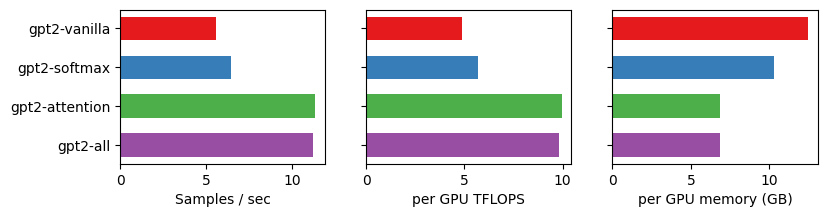

In [22]:
compare([gpt2_4_vanilla, gpt2_4_softmax, gpt2_4_attention, gpt2_4_all], 'gpt2')

## GPT-neo

In [23]:
gptneo_4_vanilla = hf(Exp('gptneo-vanilla', 'EleutherAI/gpt-neo-125m', 1, fp16=True,
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: export CUDA_VISIBLE_DEVICES=0; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_clm.py --config_name EleutherAI/gpt-neo-125m --tokenizer_name EleutherAI/gpt-neo-125m --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --per_device_train_batch_size 1 --fp16 True --bf16 False --optim adamw_hf --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/gptneo/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex --fp16_opt_level=O2 > log/log_gptneo-vanilla.txt 2>&1
Output: 
Total samples / second	: 2.2
Per GPU memory (GB)	: 8.0
Per GPU TFLOPs		: 4.4


In [24]:
gptneo_4_all = hf(Exp('gptneo-all', 'EleutherAI/gpt-neo-125m', 1, fp16=True, patch="patches/gpt_neo_all.patch",
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/gpt_neo_all.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)

Errors: error: patch failed: src/transformers/models/gpt_neo/modeling_gpt_neo.py:221
error: src/transformers/models/gpt_neo/modeling_gpt_neo.py: patch does not apply

Running command: export CUDA_VISIBLE_DEVICES=0; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_clm.py --config_name EleutherAI/gpt-neo-125m --tokenizer_name EleutherAI/gpt-neo-125m --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --per_device_train_batch_size 1 --fp16 True --bf16 False --optim adamw_hf --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/gptneo/ --overwrite_output_dir yes --skip_memory_metrics Fal

Samples / sec: ['2.23', '2.20']
per GPU TFLOPS: ['4.42', '4.35']
per GPU memory (GB): ['8.00', '8.24']


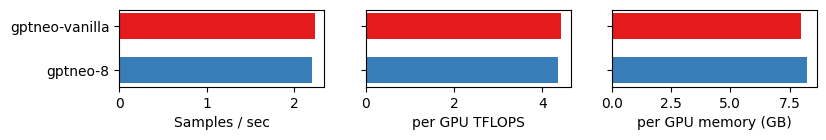

In [25]:
compare([gptneo_4_vanilla, gptneo_4_all], 'gptneo')

## Distilbert

In [26]:
distilbert_8_vanilla = hf(Exp('distilbert-base', 'distilbert-base-uncased', 4, fp16=True, 
                    kwargs={"flags": ["--fp16_opt_level=O2"]}))
sleep(5)

Running command: export CUDA_VISIBLE_DEVICES=0; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name distilbert-base-uncased --tokenizer_name distilbert-base-uncased --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 512 --per_device_train_batch_size 4 --fp16 True --bf16 False --optim adamw_hf --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False  > log/log_distilbert-base.txt 2>&1
Output: 
Total samples / second	: 25.6
Per GPU memory (GB)	: 3.0
Per GPU TFLOPs		: 5.5


In [28]:
distilbert_8_all = hf(Exp('distilbert-all', 'distilbert-base-uncased', 4, fp16=True, patch="patches/distilbert_all.patch",
                    kwargs={"flags": ["--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/distilbert_all.patch; git diff src/transformers/models/
Output: No local changes to save

Errors: error: patch failed: src/transformers/models/distilbert/modeling_distilbert.py:223
error: src/transformers/models/distilbert/modeling_distilbert.py: patch does not apply

Running command: export CUDA_VISIBLE_DEVICES=0; torchrun --nproc_per_node 1 transformers/examples/pytorch/language-modeling/run_mlm.py --config_name distilbert-base-uncased --tokenizer_name distilbert-base-uncased --dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 --do_train --max_seq_length 512 --per_device_train_batch_size 4 --fp16 True --bf16 False --optim adamw_hf --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False --fp16_opt_level=O2 > log/log_distilbert-6.tx

Samples / sec: ['25.57', '25.82']
per GPU TFLOPS: ['5.55', '5.60']
per GPU memory (GB): ['3.00', '3.00']


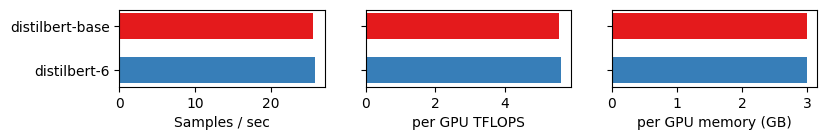

In [29]:
compare([distilbert_8_vanilla, distilbert_8_all], 'distilbert')

## Resnet

In [30]:
resnet_8_vanilla = hf(Exp('resnet-base', 'microsoft/resnet-50', 8, fp16=True,
                    kwargs={"flags": ["--fp16_opt_level=O2"]}))
sleep(5)

Running command: export CUDA_VISIBLE_DEVICES=0; torchrun --nproc_per_node 1 transformers/examples/pytorch/image-classification/run_image_classification.py --model_name_or_path microsoft/resnet-50 --dataset_name beans --do_train --per_device_train_batch_size 8 --fp16 True --bf16 False --optim adamw_hf --max_steps 20 --gradient_accumulation_steps 1 --gradient_checkpointing False --output_dir /tmp/beans/ --overwrite_output_dir yes --skip_memory_metrics False --remove_unused_columns False --learning_rate 2e-5 --ignore_mismatched_sizes --fp16_opt_level=O2 > log/log_resnet-base.txt 2>&1
Output: 
Total samples / second	: 33.7
Per GPU memory (GB)	: 0.7
Per GPU TFLOPs		: 0.0


In [31]:
resnet_8_all = hf(Exp('resnet-all', 'microsoft/resnet-50', 8, fp16=True, patch='patches/resnet_all.patch',
                    kwargs={"flags": ["--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/resnet_all.patch; git diff src/transformers/models/
Output: No local changes to save
diff --git a/src/transformers/models/resnet/modeling_resnet.py b/src/transformers/models/resnet/modeling_resnet.py
index f2d207c21..29959c702 100644
--- a/src/transformers/models/resnet/modeling_resnet.py
+++ b/src/transformers/models/resnet/modeling_resnet.py
@@ -68,6 +68,8 @@ class ResNetConvLayer(nn.Module):
             in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size // 2, bias=False
         )
         self.normalization = nn.BatchNorm2d(out_channels)
+        from epoi.ops.torchscript_ops import FusedConvBN
+        self.conv_batchnorm = FusedConvBN(in_channels, out_channels, kernel_size, stride)
         self.activation = ACT2FN[activation] if activation is not None else nn.Identity()
 
     def forward(self, input

Samples / sec: ['33.69', '60.23']
per GPU TFLOPS: ['0.00', '0.00']
per GPU memory (GB): ['0.75', '0.84']


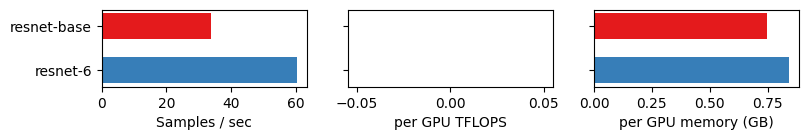

In [32]:
compare([resnet_8_vanilla, resnet_8_all], 'resnet')

## T5

In [33]:
t5_8_vanilla = hf(Exp('t5-vanilla', 't5-base', 8, fp16=True,
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: export CUDA_VISIBLE_DEVICES=0;     torchrun --nproc_per_node 1 transformers/examples/pytorch/translation/run_translation.py     --model_name_or_path t5-base     --do_train     --source_lang en     --target_lang ro     --source_prefix "translate English to Romanian: "     --dataset_name wmt16     --dataset_config_name ro-en     --output_dir /tmp/tst-translation     --per_device_train_batch_size=8     --overwrite_output_dir     --predict_with_generate     --fp16 True --bf16 False     --optim adamw_hf --max_steps 20     --gradient_accumulation_steps 1     --gradient_checkpointing False     --output_dir /tmp/t5/ --overwrite_output_dir yes --skip_memory_metrics False --half_precision_backend=apex > log/log_t5-vanilla.txt 2>&1
Output: 
Total samples / second	: 28.9
Per GPU memory (GB)	: 5.2
Per GPU TFLOPs		: 0.0


In [34]:
t5_8_attn = hf(Exp('t5-attn', 't5-base', 8, fp16=True, patch='patches/t5_attn.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/t5_attn.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/t5/modeling_t5.py b/src/transformers/models/t5/modeling_t5.py
index 0e7237ea3..8276d17d4 100644
--- a/src/transformers/models/t5/modeling_t5.py
+++ b/src/transformers/models/t5/modeling_t5.py
@@ -584,7 +584,8 @@ class T5Attention(nn.Module):
 class T5LayerSelfAttention(nn.Module):
     def __init__(self, config, has_relative_attention_bias=False):
         super().__init__()
-        self.SelfAttention = T5Attention(config, has_relative_attention_bias=has_relative_attention_bias)
+        from epoi.ops.xformers_attn import T5Attention
+        self.SelfAttention = T5Attention(config, has_relative_attention_bias = has_relative_attention_bias, attn

In [35]:
t5_8_softmax = hf(Exp('t5-softmax', 't5-base', 8, fp16=True, patch='patches/t5_softmax.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/t5_softmax.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/t5/modeling_t5.py b/src/transformers/models/t5/modeling_t5.py
index 0e7237ea3..a2c1ac133 100644
--- a/src/transformers/models/t5/modeling_t5.py
+++ b/src/transformers/models/t5/modeling_t5.py
@@ -559,7 +559,8 @@ class T5Attention(nn.Module):
             position_bias_masked = position_bias
 
         scores += position_bias_masked
-        attn_weights = nn.functional.softmax(scores.float(), dim=-1).type_as(
+        from xformers.triton.softmax import softmax
+        attn_weights = softmax(scores.float()).type_as(
             scores
         )  # (batch_size, n_heads, seq_length, key_length)
         attn_weights = nn.functional.dropout(



In [36]:
t5_8_all = hf(Exp('t5-all', 't5-base', 8, fp16=True, patch='patches/t5_all.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/t5_all.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/t5/modeling_t5.py b/src/transformers/models/t5/modeling_t5.py
index 0e7237ea3..477f32241 100644
--- a/src/transformers/models/t5/modeling_t5.py
+++ b/src/transformers/models/t5/modeling_t5.py
@@ -559,7 +559,8 @@ class T5Attention(nn.Module):
             position_bias_masked = position_bias
 
         scores += position_bias_masked
-        attn_weights = nn.functional.softmax(scores.float(), dim=-1).type_as(
+        from xformers.triton.softmax import softmax
+        attn_weights = softmax(scores.float()).type_as(
             scores
         )  # (batch_size, n_heads, seq_length, key_length)
         attn_weights = nn.functional.dropout(
@@ -5

Samples / sec: ['28.93', '0.40', '32.65', '31.97']
per GPU TFLOPS: ['0.00', '0.00', '0.00', '0.00']
per GPU memory (GB): ['5.22', '4.86', '4.54', '4.54']


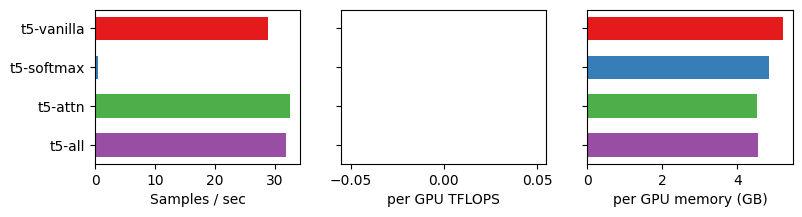

In [37]:
compare([t5_8_vanilla, t5_8_softmax, t5_8_attn, t5_8_all], 't5')

## GroupVit

In [38]:
groupvit_8_vanilla = hf(Exp('groupvit-vanilla', 'nvidia/groupvit-gcc-yfcc', 8, fp16=True, patch='patches/groupvit_base.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/groupvit_base.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/groupvit/modeling_groupvit.py b/src/transformers/models/groupvit/modeling_groupvit.py
index 59ff60ed7..7f3927ca0 100644
--- a/src/transformers/models/groupvit/modeling_groupvit.py
+++ b/src/transformers/models/groupvit/modeling_groupvit.py
@@ -446,6 +446,7 @@ class GroupViTTextEmbeddings(nn.Module):
         super().__init__()
         embed_dim = config.hidden_size
 
+        config.max_position_embeddings = 256
         self.token_embedding = nn.Embedding(config.vocab_size, embed_dim)
         self.position_embedding = nn.Embedding(config.max_position_embeddings, embed_dim)
 

Running command: export CUDA_VISIBLE_DEVICES=0; torchrun --npr

In [39]:
groupvit_8_all = hf(Exp('groupvit-all', 'nvidia/groupvit-gcc-yfcc', 8, fp16=True, patch='patches/groupvit_all.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/groupvit_all.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/groupvit/modeling_groupvit.py b/src/transformers/models/groupvit/modeling_groupvit.py
index 59ff60ed7..7f3927ca0 100644
--- a/src/transformers/models/groupvit/modeling_groupvit.py
+++ b/src/transformers/models/groupvit/modeling_groupvit.py
@@ -446,6 +446,7 @@ class GroupViTTextEmbeddings(nn.Module):
         super().__init__()
         embed_dim = config.hidden_size
 
+        config.max_position_embeddings = 256
         self.token_embedding = nn.Embedding(config.vocab_size, embed_dim)
         self.position_embedding = nn.Embedding(config.max_position_embeddings, embed_dim)
 

Running command: export CUDA_VISIBLE_DEVICES=0; torchrun --npro

Samples / sec: ['27.96', '35.03']
per GPU TFLOPS: ['0.00', '0.00']
per GPU memory (GB): ['1.46', '1.18']


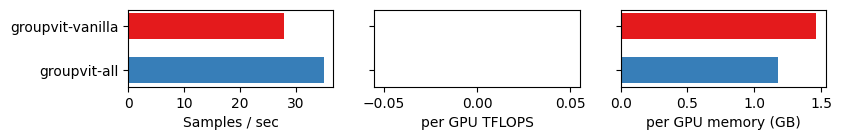

In [40]:
compare([groupvit_8_vanilla, groupvit_8_all], 'groupvit')

## Albert

In [42]:
albert_8_vanilla = hf(Exp('albert-base', 'albert-base-v2', 8, fp16=True, patch='patches/albert_vanilla.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/albert_vanilla.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/albert/modeling_albert.py b/src/transformers/models/albert/modeling_albert.py
index fe6b37732..532193e09 100755
--- a/src/transformers/models/albert/modeling_albert.py
+++ b/src/transformers/models/albert/modeling_albert.py
@@ -382,6 +382,7 @@ class AlbertLayer(nn.Module):
         self.attention = AlbertAttention(config)
         self.ffn = nn.Linear(config.hidden_size, config.intermediate_size)
         self.ffn_output = nn.Linear(config.intermediate_size, config.hidden_size)
+        config.hidden_act = "gelu"
         self.activation = ACT2FN[config.hidden_act]
         self.dropout = nn.Dropout(config.hidden_dropout_prob)
 

Running c

In [43]:
albert_8_softmax = hf(Exp('albert-softmax', 'albert-base-v2', 8, fp16=True, patch='patches/albert_softmax.patch',
                    kwargs={"flags": ["--half_precision_backend=apex", "--fp16_opt_level=O2"]}))
sleep(5)

Running command: cd /home/ubuntu/pytorch-opt/transformers-benchmarks/transformers; git stash push -- src/transformers/models/; git apply patches/albert_softmax.patch; git diff src/transformers/models/
Output: Saved working directory and index state WIP on (no branch): ef42cb627 Fix TensorFlow pakage check (#26842)
diff --git a/src/transformers/models/albert/modeling_albert.py b/src/transformers/models/albert/modeling_albert.py
index fe6b37732..294fe3dbc 100755
--- a/src/transformers/models/albert/modeling_albert.py
+++ b/src/transformers/models/albert/modeling_albert.py
@@ -352,7 +352,8 @@ class AlbertAttention(nn.Module):
                 attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key
 
         # Normalize the attention scores to probabilities.
-        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
+        from xformers.triton.softmax import softmax as softmax_softmax
+        attention_probs = softmax_softmax(

Samples / sec: ['36.42', '19.52']
per GPU TFLOPS: ['13.14', '7.04']
per GPU memory (GB): ['3.24', '3.44']


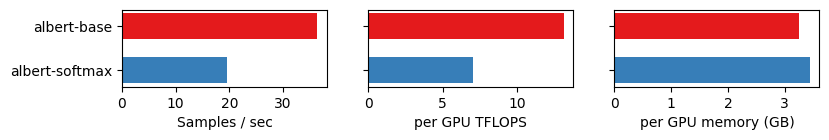

In [44]:
compare([albert_8_vanilla, albert_8_softmax], 'albert')

python examples/pytorch/translation/run_translation.py --model_name_or_path t5-small --do_train --source_lang en --target_lang ro --source_prefix "translate English to Romanian: " --dataset_name wmt16 --dataset_config_name ro-en --output_dir /tmp/tst-translation --per_device_train_batch_size=4 --per_device_eval_batch_size=4 --overwrite_output_dir --predict_with_generate